# Bank Product Marketing prediction

### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV,KFold
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

from pandas.api.types import CategoricalDtype

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
df.y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

### Exploratory Data Analysis (EDA) and Data Preprocessing (DP)

In [5]:
# check the duplication and drop them
duplicate = df.duplicated().sum()
if duplicate==0:
    print('no duplicated index')
else:
    df.drop_duplicates(inplace = True) 
    print('drop {0:3d} duplicated rows'.format(duplicate))

drop  12 duplicated rows


In [6]:
#split dataset into X,y
y = pd.get_dummies(df['y'],prefix='y',drop_first = True)
X = df.drop('y',axis=1)

In [7]:
# according to the dataset information about 'duration' feature, it will be excluded from our analysis.
X.drop('duration',inplace = True, axis=1)
X.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
dtype: object

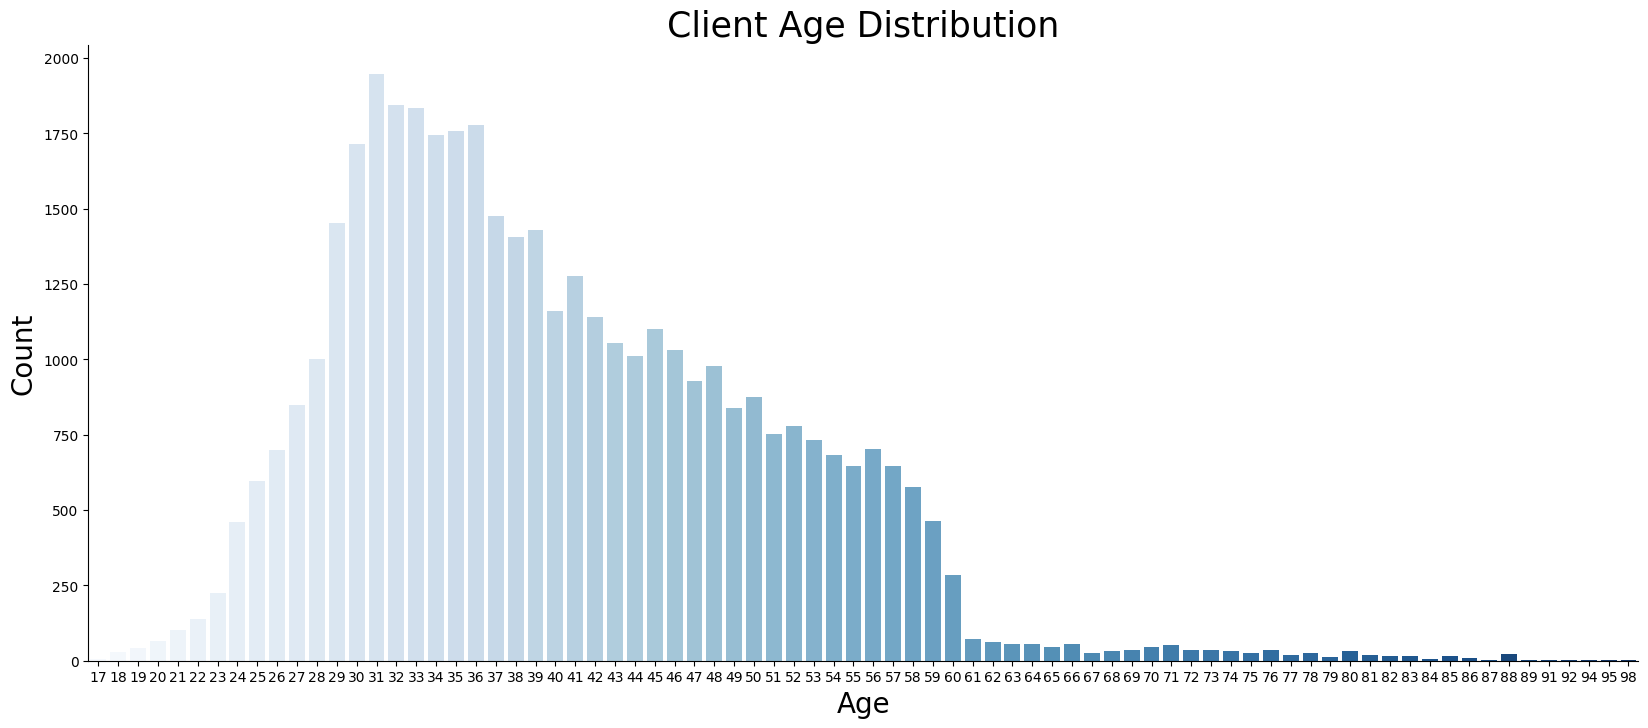

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x = 'age', data = X, palette = 'Blues')
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.set_title('Client Age Distribution', fontsize=25)
sns.despine()

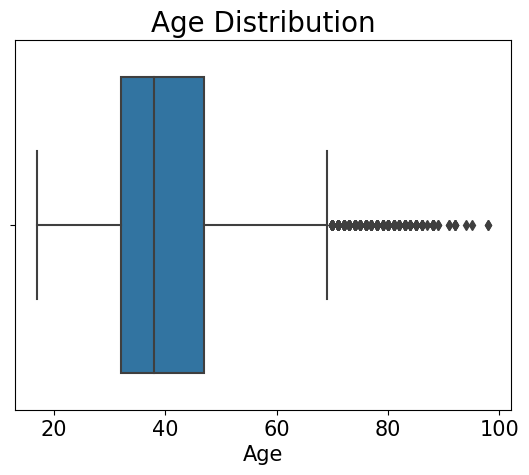

In [9]:
fig, ax = plt.subplots()
sns.boxplot(x = 'age', data = X, orient = 'h')
ax.set_xlabel('Age', fontsize=15)
ax.set_title('Age Distribution', fontsize=20)
ax.tick_params(labelsize=15)

In [10]:
# Quartiles
print('1st Quartile: ', X['age'].quantile(q = 0.25))
print('2nd Quartile: ', X['age'].quantile(q = 0.50))
print('3rd Quartile: ', X['age'].quantile(q = 0.75))
print('4th Quartile: ', X['age'].quantile(q = 1.00))
#Calculate the outliers:
  # Interquartile range, IQR = Q3 - Q1
  # lower 1.5*IQR whisker = Q1 - 1.5 * IQR 
  # Upper 1.5*IQR whisker = Q3 + 1.5 * IQR   
print('Ages above', X['age'].quantile(q = 0.75) + 
                      1.5*(X['age'].quantile(q = 0.75) - X['age'].quantile(q = 0.25)), 'are outliers')

1st Quartile:  32.0
2nd Quartile:  38.0
3rd Quartile:  47.0
4th Quartile:  98.0
Ages above 69.5 are outliers


In [11]:
print('Numerber of outliers: ', X[X['age'] > 69.5]['age'].count())
print('Number of clients: ', len(X))
print('Outliers are:', round(X[X['age'] > 69.5]['age'].count()*100/len(X),2), '%')

Numerber of outliers:  468
Number of clients:  41176
Outliers are: 1.14 %


As we can see in above results, the age range of our clients is large. The dispersion of age is little higher than medium. 

In [12]:
print('Jobs: ', X['job'].unique())

Jobs:  ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']


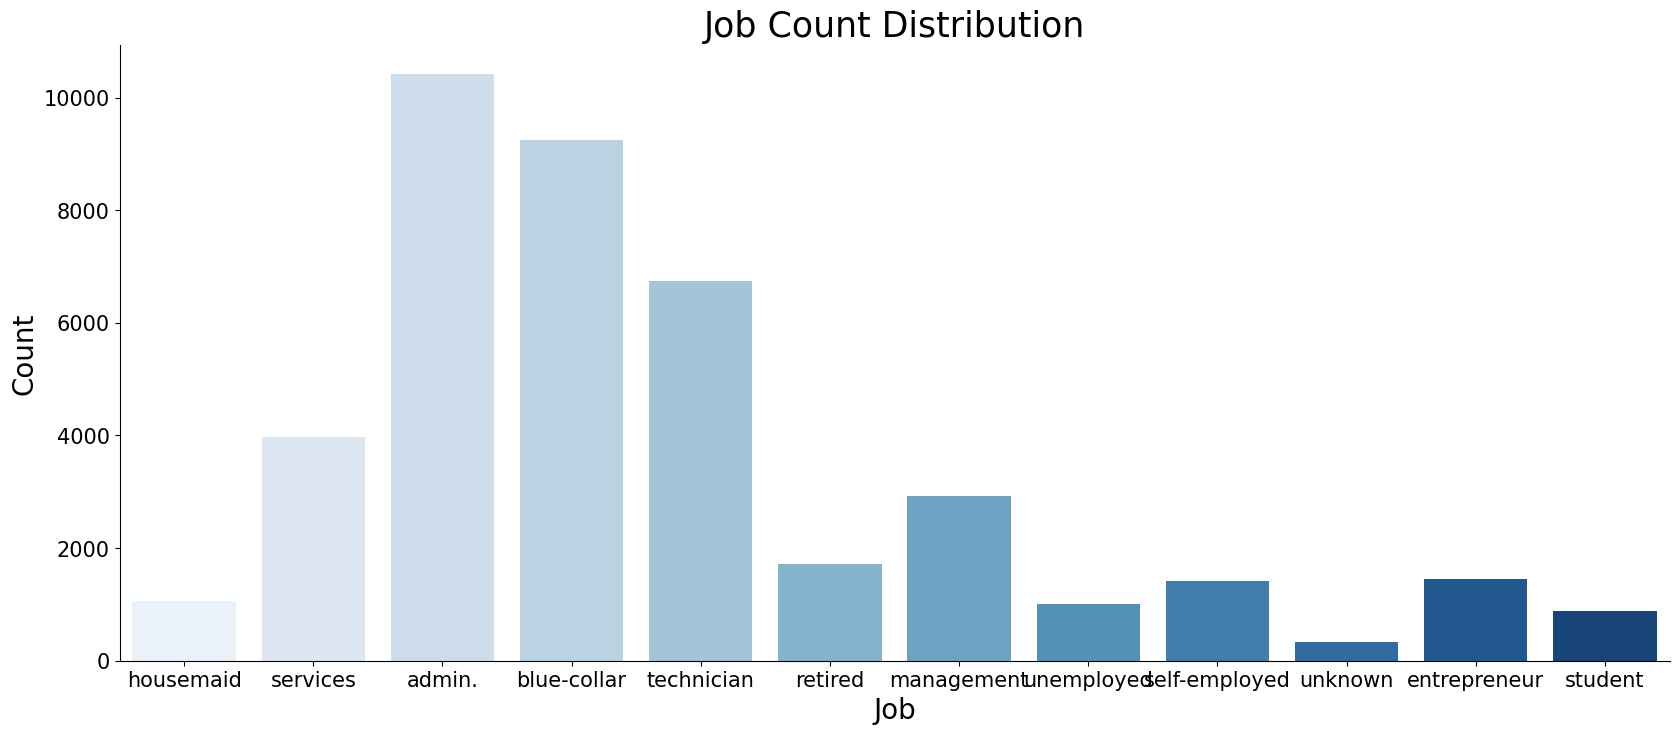

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x = 'job', data = X, palette = 'Blues')
ax.set_xlabel('Job', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.set_title('Job Count Distribution', fontsize=25)
ax.tick_params(labelsize=15)
sns.despine()

In [14]:
print('Marital Status: ', X['marital'].unique())

Marital Status:  ['married' 'single' 'divorced' 'unknown']


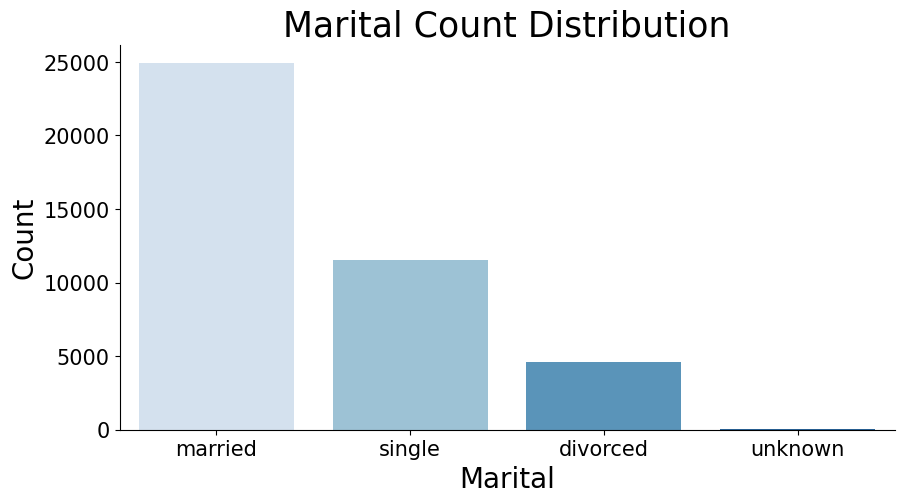

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
sns.countplot(x = 'marital', data = X, palette = 'Blues')
ax.set_xlabel('Marital', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.set_title('Marital Count Distribution', fontsize=25)
ax.tick_params(labelsize=15)
sns.despine()

In [16]:
print('Education: ', X['education'].unique())

Education:  ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']


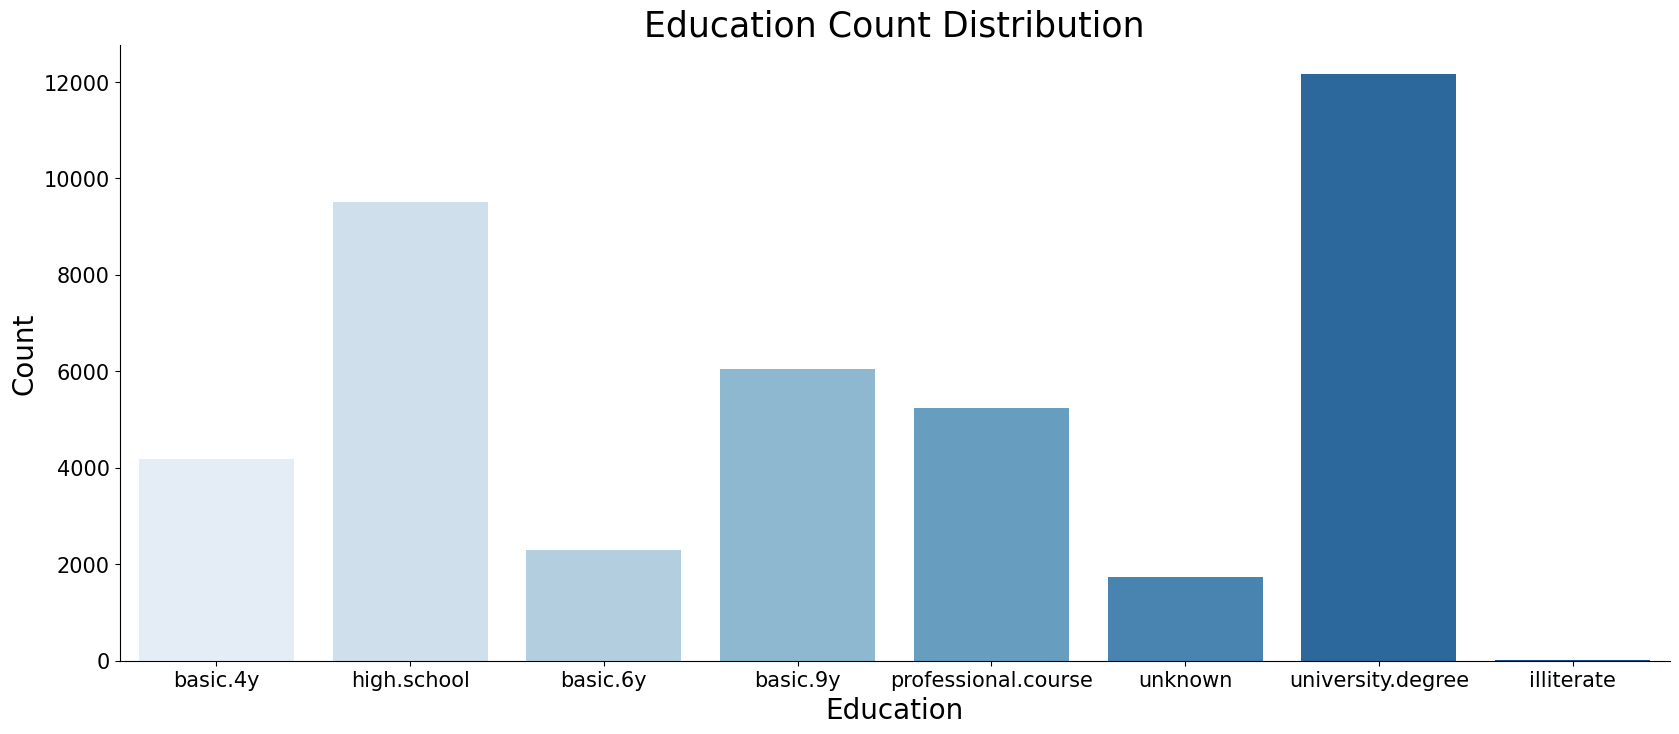

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x = 'education', data = X, palette = 'Blues')
ax.set_xlabel('Education', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.set_title('Education Count Distribution', fontsize=25)
ax.tick_params(labelsize=15)
sns.despine()

In [18]:
print('Default: ', X['default'].unique())
print('Housing: ', X['housing'].unique())
print('Loan: ', X['loan'].unique())

Default:  ['no' 'unknown' 'yes']
Housing:  ['no' 'yes' 'unknown']
Loan:  ['no' 'yes' 'unknown']


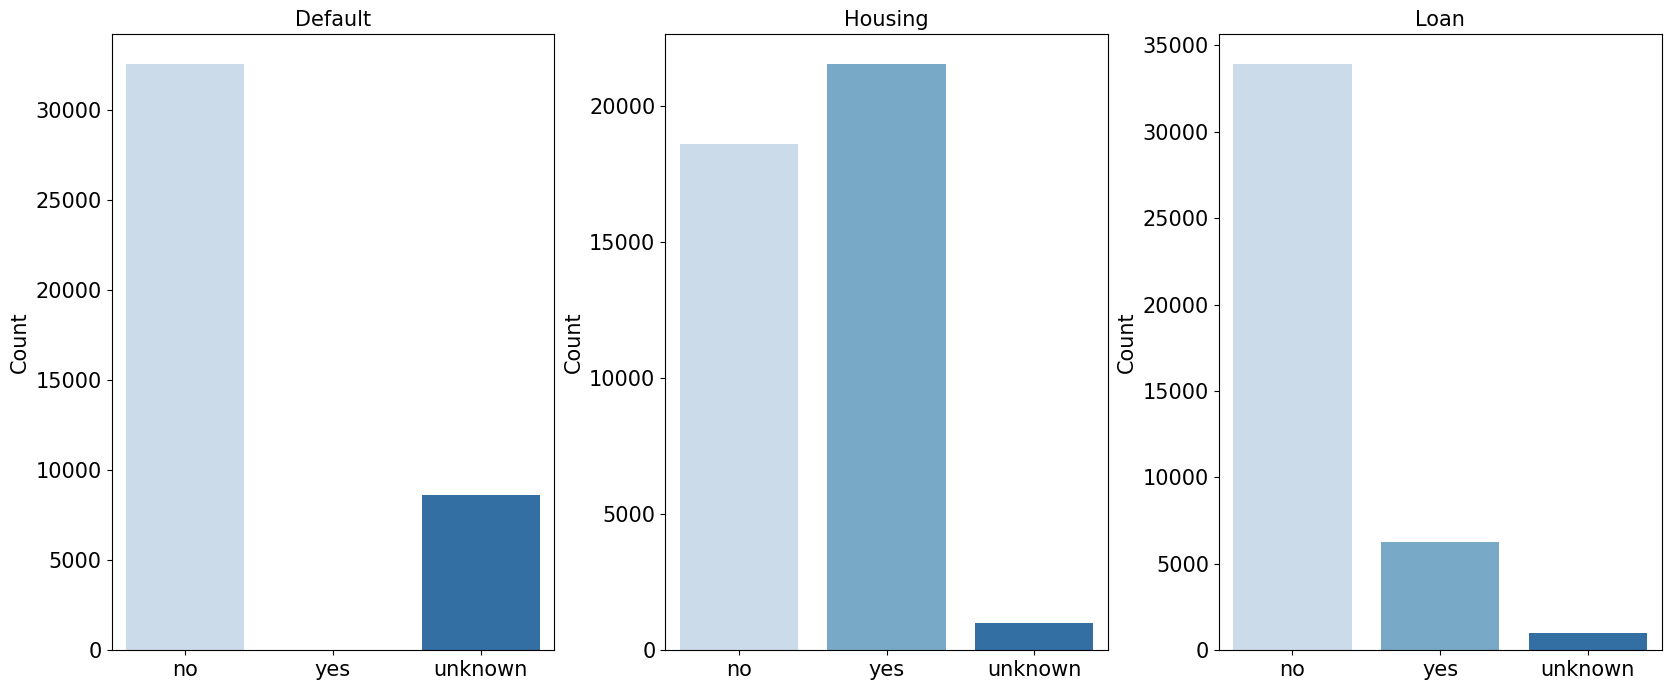

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (20,8))
# Default, has credit in default?
sns.countplot(x = 'default', data = X, ax = ax1, order =['no','yes','unknown'], palette = 'Blues')
ax1.set_title('Default', fontsize=15)
ax1.set_xlabel('')
ax1.set_ylabel('Count', fontsize=15)
ax1.tick_params(labelsize=15)

# Housing, has housing loan?
sns.countplot(x = 'housing', data = X, ax = ax2, palette = 'Blues')
ax2.set_title('Housing', fontsize=15)
ax2.set_xlabel('')
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)

# Loan, has personal loan?
sns.countplot(x = 'loan', data = X, ax = ax3, palette = 'Blues')
ax3.set_title('Loan', fontsize=15)
ax3.set_xlabel('')
ax3.set_ylabel('Count', fontsize=15)
ax3.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.25)

The distribution of clients' job types is uneven. 
Most clients are married. 
The higher the education level , the greater the amount of clients.
Most of clients don't have credit in default but have personal loan. The amount of clients with housing loan is a little higher than clients without housing loan.

In [20]:
print('Contact: ', X['contact'].unique())

Contact:  ['telephone' 'cellular']


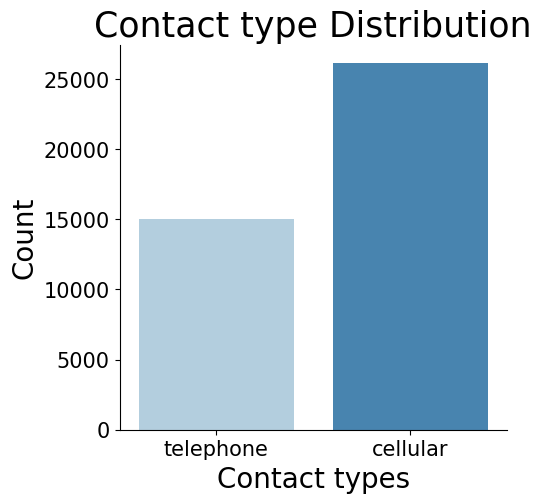

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
sns.countplot(x = 'contact', data = X, palette = 'Blues')
ax.set_xlabel('Contact types', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.set_title('Contact type Distribution', fontsize=25)
ax.tick_params(labelsize=15)
sns.despine()

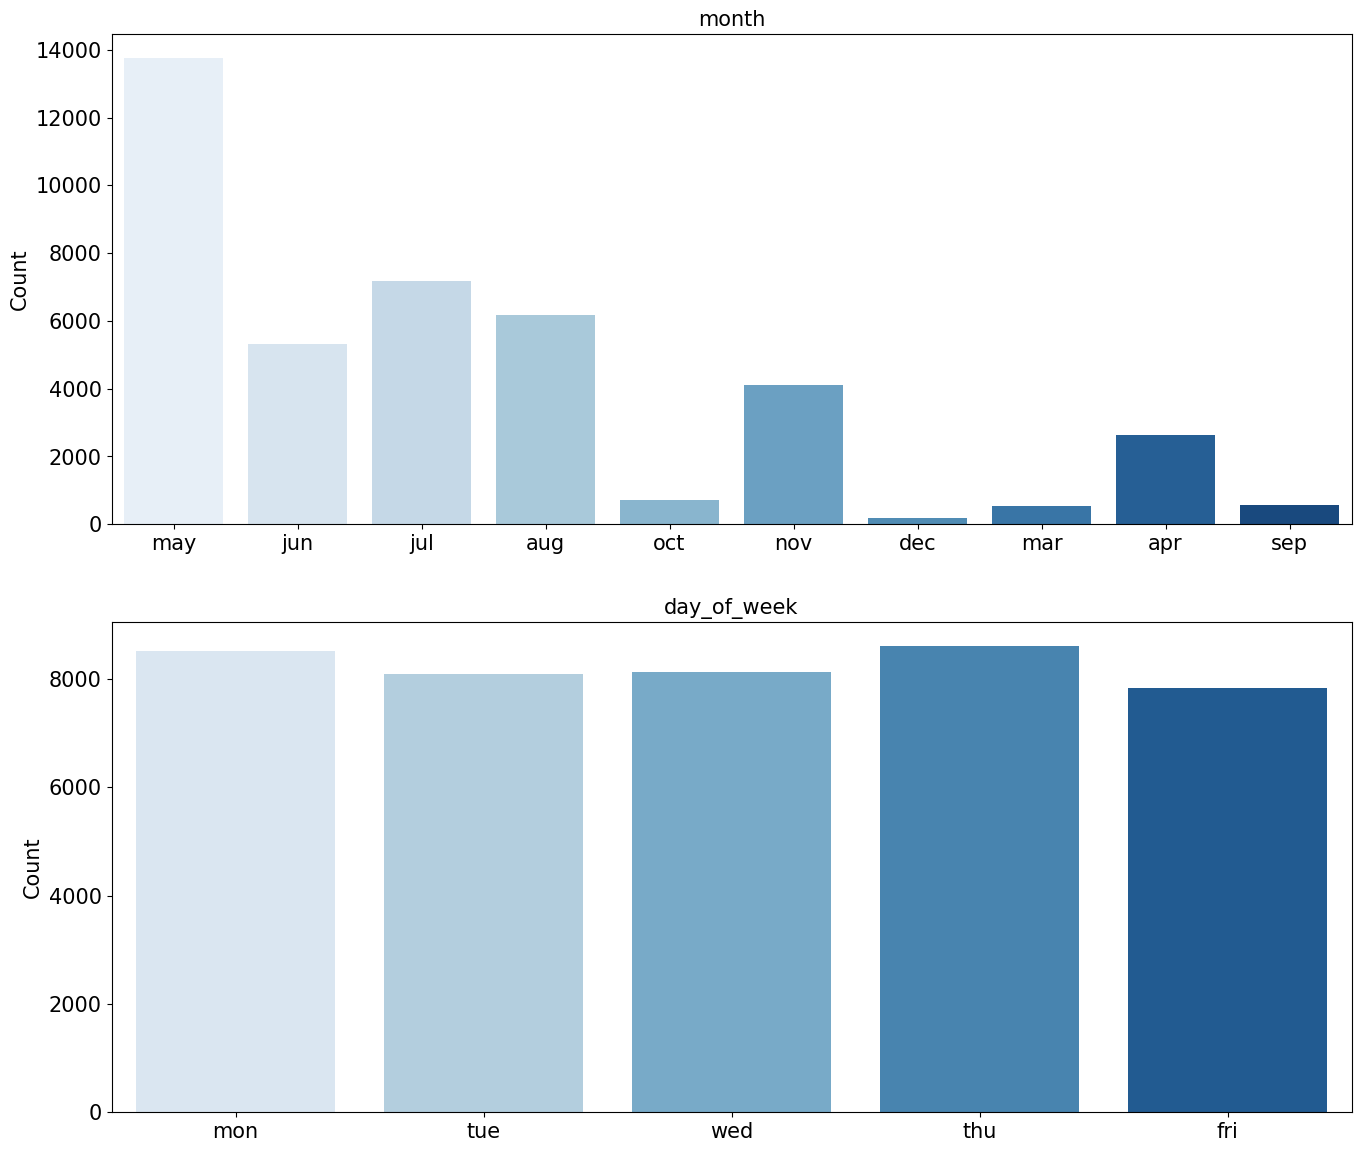

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (16,14))

sns.countplot(x = 'month', data = X, ax = ax1, palette = 'Blues')
ax1.set_title('month', fontsize=15)
ax1.set_xlabel('')
ax1.set_ylabel('Count', fontsize=15)
ax1.tick_params(labelsize=15)

sns.countplot(x = 'day_of_week', data = X, ax = ax2, palette = 'Blues')
ax2.set_title('day_of_week', fontsize=15)
ax2.set_xlabel('')
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.25)

We can see that more clients use cellular.
And the amount of contact is higher in May.

In [23]:
print('Poutcome: ',X['poutcome'].unique())

Poutcome:  ['nonexistent' 'failure' 'success']


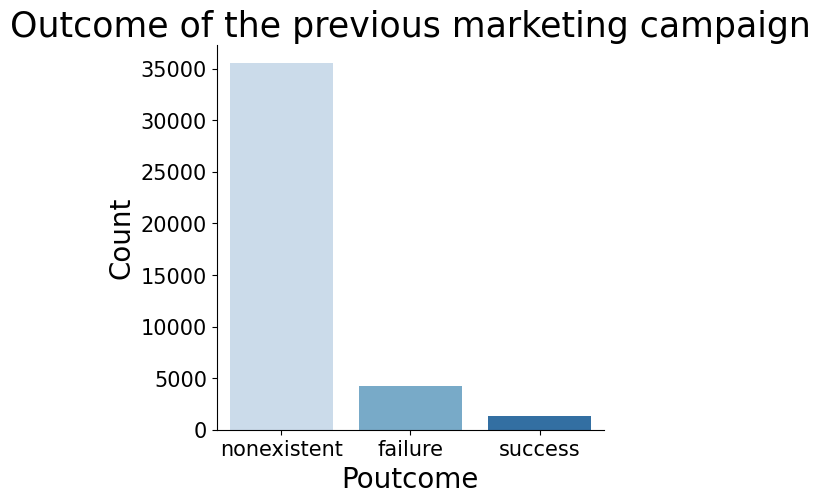

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
sns.countplot(x = 'poutcome', data = X, palette = 'Blues')
ax.set_xlabel('Poutcome', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.set_title('Outcome of the previous marketing campaign', fontsize=25)
ax.tick_params(labelsize=15)
sns.despine()

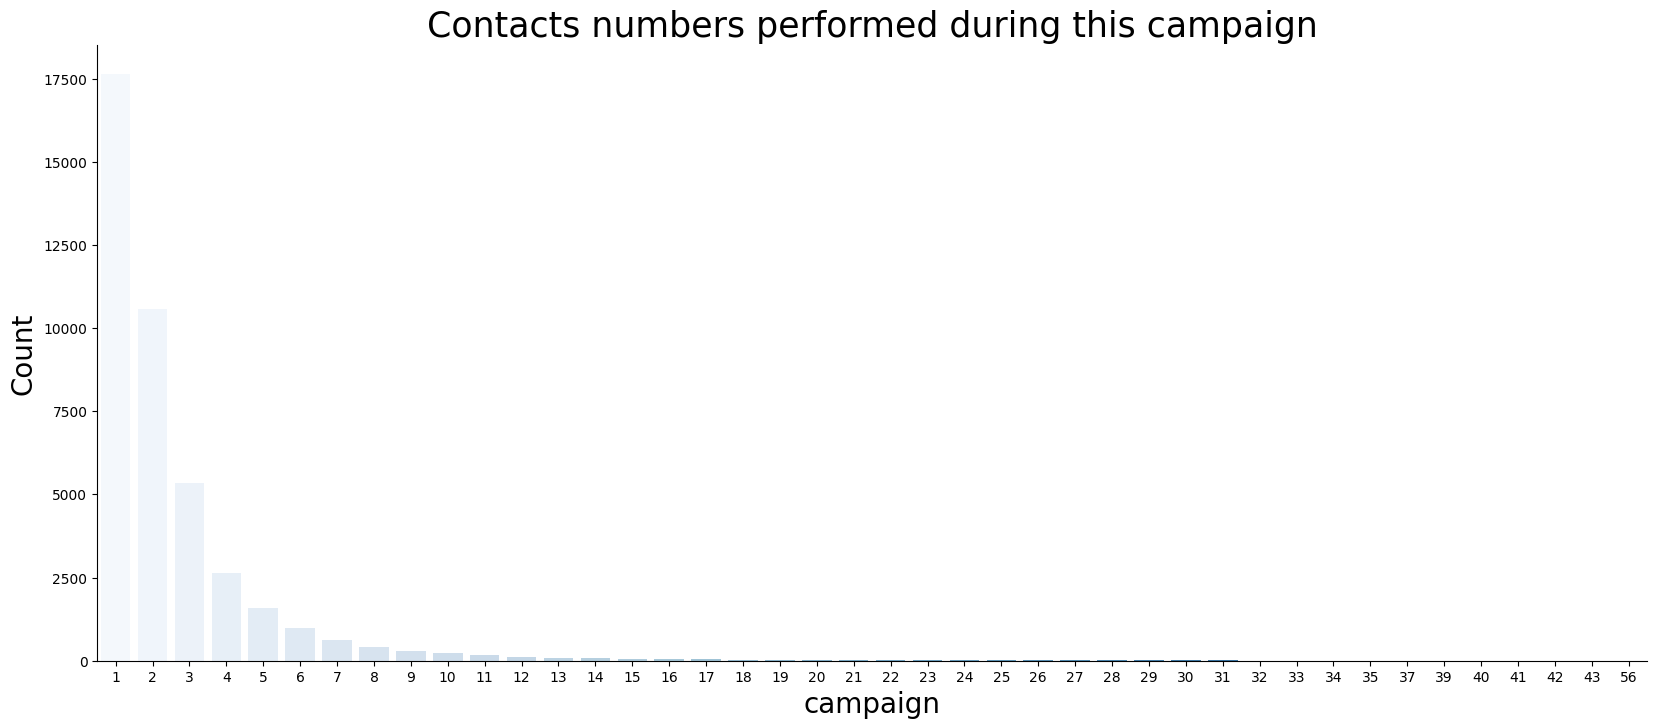

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x = 'campaign', data = X, palette = 'Blues')
ax.set_xlabel('campaign', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.set_title('Contacts numbers performed during this campaign', fontsize=25)
sns.despine()

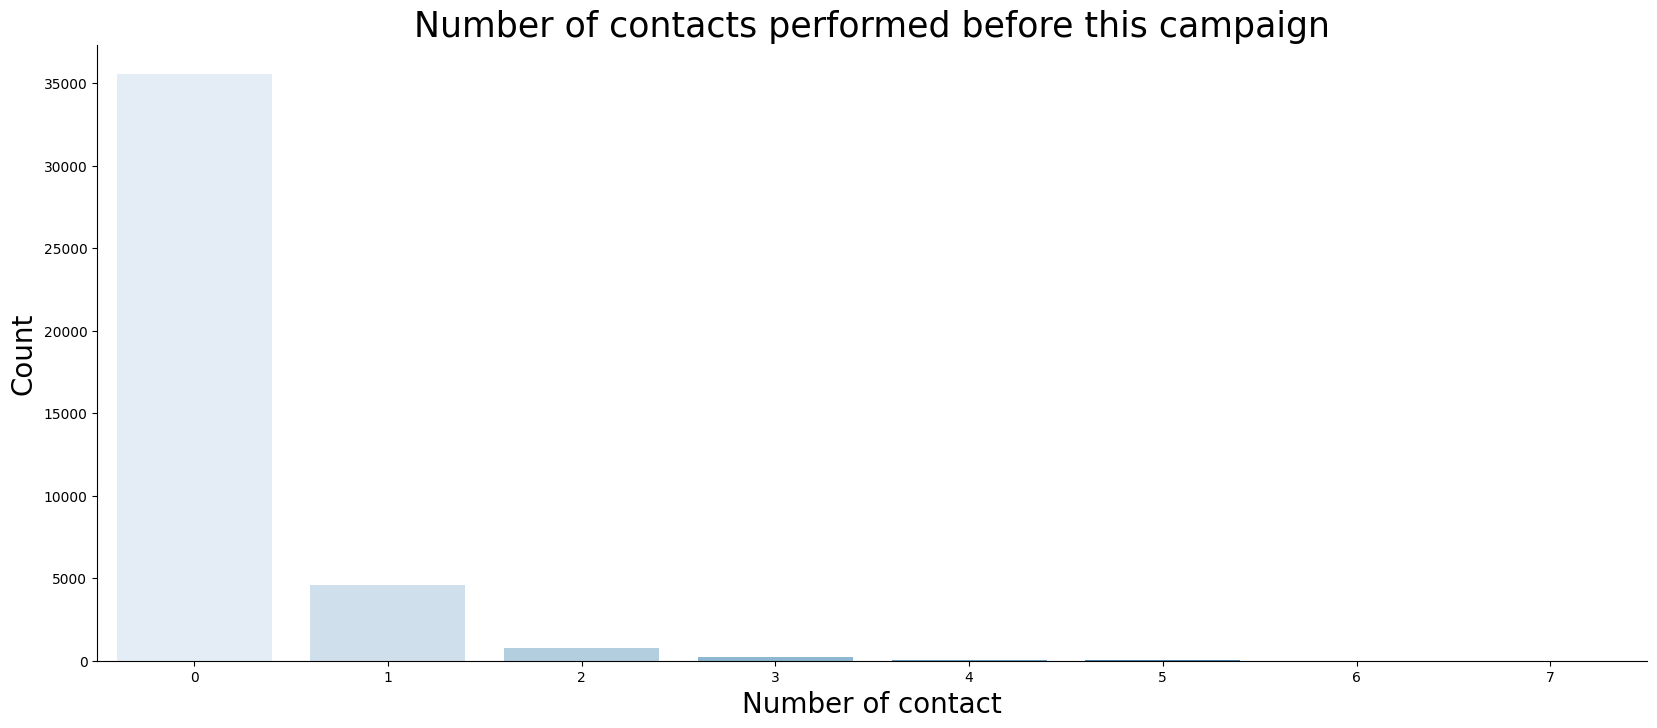

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x = 'previous', data = X, palette = 'Blues')
ax.set_xlabel('Number of contact', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.set_title('Number of contacts performed before this campaign', fontsize=25)
sns.despine()

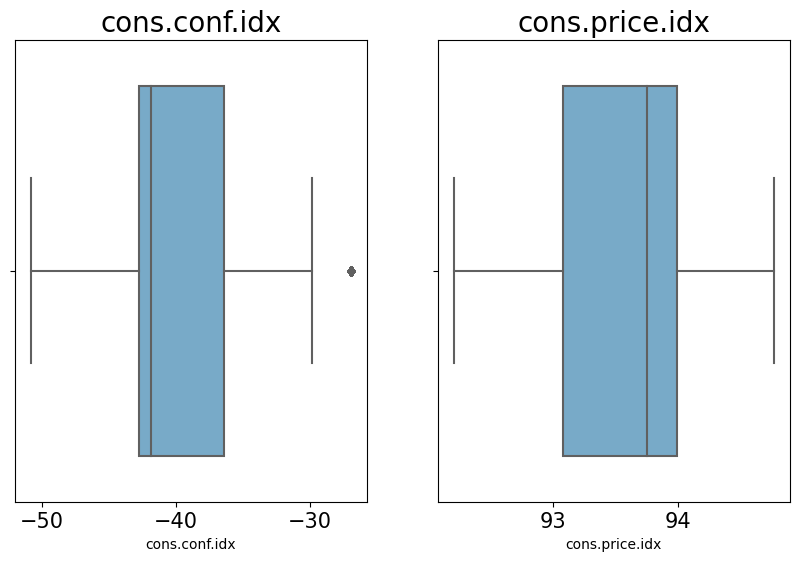

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,6))
sns.boxplot(x = 'cons.conf.idx', data = X, ax= ax1, orient = 'v', palette = 'Blues')
ax1.set_title('cons.conf.idx', fontsize=20)
ax1.tick_params(labelsize=15)

sns.boxplot(x = 'cons.price.idx', data = X, ax= ax2, orient = 'v', palette = 'Blues')
ax2.set_title('cons.price.idx', fontsize=20)
ax2.tick_params(labelsize=15)

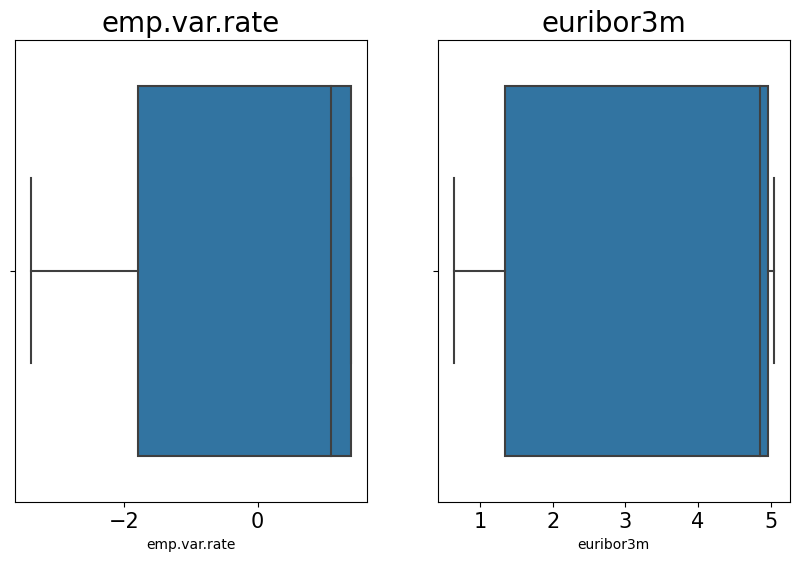

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,6))
sns.boxplot(x = 'emp.var.rate', data = X, ax= ax1, orient = 'v')
ax1.set_title('emp.var.rate', fontsize=20)
ax1.tick_params(labelsize=15)

sns.boxplot(x = 'euribor3m', data = X, ax= ax2, orient = 'v')
ax2.set_title('euribor3m', fontsize=20)
ax2.tick_params(labelsize=15)

In [29]:
X['emp.var.rate'].mean()

0.08192150767437315

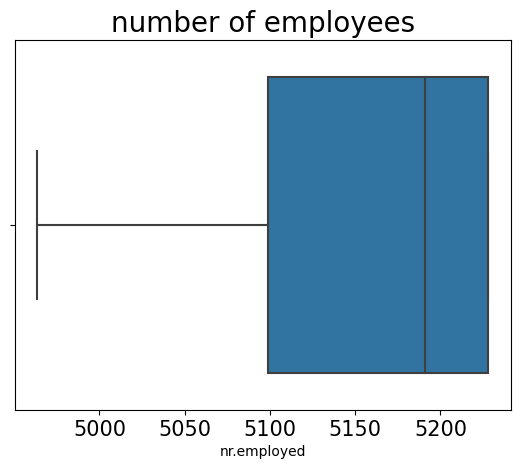

In [30]:
fig,ax = plt.subplots()
sns.boxplot(x = 'nr.employed', data = X, orient = 'h')
ax.set_title('number of employees', fontsize=20)
ax.tick_params(labelsize=15)

In [31]:
print(X['nr.employed'].mean())

5167.034869827084


### Feature Engineering (FE) and Feature Selection (FS) 

In [32]:
#split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=3)

In [33]:
#num_features = train.select_dtypes(include=['int64', 'float64']).columns
num_features = ["age", "campaign", "pdays", "previous", "emp.var.rate", 
                "cons.price.idx", "cons.conf.idx","euribor3m", "nr.employed"]

cat_features = ["job", "marital", "education","default", "housing", "loan",
                "contact", "month", "day_of_week", "poutcome"]

In [34]:
# scale the numerical features
# transform the categorical features by one hot encoding
preprocessor = ColumnTransformer([("numerical", StandardScaler(), num_features), 
                                  ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"),cat_features)])

### Model Building

In [35]:
#define pipeline 
# classifiers = [LogisticRegression(class_weight='balanced',solver='liblinear',random_state=3),
#                KNeighborsClassifier(n_neighbors = 5, class_weight = 'balanced'),
#                DecisionTreeClassifier(class_weight="balanced"),
#                RandomForestClassifier(class_weight="balanced", n_estimators=50, n_jobs=-1),
#                XGBClassifier(scale_pos_weight=(1 - y.mean()), n_jobs=-1)
#               ]
lr_model = Pipeline([("preprocessor", preprocessor), 
                     ("classifier", LogisticRegression(class_weight="balanced", solver='liblinear', random_state=3))])
kn_model = Pipeline([("preprocessor", preprocessor), 
                     ("classifier",KNeighborsClassifier(n_neighbors = 5, weights = 'uniform'))])
#decision tree
dt_model = Pipeline([("preprocessor", preprocessor), 
                     ("classifier", DecisionTreeClassifier(class_weight="balanced"))])
#random forest
rf_model = Pipeline([("preprocessor", preprocessor), 
                     ("classifier", RandomForestClassifier(class_weight="balanced", n_estimators=50, n_jobs=-1))])
xgb_model = Pipeline([("preprocessor", preprocessor), 
                      # Add the scale_pos_weight to make it balanced
                      ("classifier", XGBClassifier(scale_pos_weight=float(1 - y.mean()), n_jobs=-1))])
                     

In [36]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=3)

### Logistic Regression

In [37]:
#tune logistic regression
lr_gs = GridSearchCV(lr_model, {"classifier__C": [1, 1.3, 1.5],"classifier__penalty":['l1','l2']},
                    n_jobs=1, cv=k_fold, scoring='accuracy',error_score=0)


In [38]:
lr_gs.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=3, shuffle=True), error_score=0,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                                                          'emp.var.rate',
                                                                          'cons.price.idx',
                                                                          'cons.conf.idx',
                                                                          'euribor3m',
                                                                          'nr.employed']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week',
                                                                          'poutcome'])])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=3,
                                                           solver='liblinear'))]),
             n_jobs=1,
             param_grid={'classifier__C': [1, 1.3, 1.5],
                         'classifier__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [39]:
print('best parameters: ', lr_gs.best_params_)
print('best score: ', lr_gs.best_score_)

best parameters:  {'classifier__C': 1.5, 'classifier__penalty': 'l1'}
best score:  0.8275349119611415


In [40]:
lr_model.set_params(**lr_gs.best_params_)
lr_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('classifier',
                 LogisticRegression(C=1.5, class_weight='balanced',
                                    penalty='l1', random_state=3,
                                    solver='liblinear'))])

In [41]:
y_pred_lr = lr_model.predict(X_test)

In [42]:
print('accuracy score: ', accuracy_score(y_test,y_pred_lr))
print('confusion_mat『rix:\n',confusion_matrix(y_test,y_pred_lr))
print('report: \n', classification_report(y_test,y_pred_lr))

accuracy score:  0.825643516270034
confusion_mat『rix:
 [[6217 1091]
 [ 345  583]]
report: 
               precision    recall  f1-score   support

           0       0.95      0.85      0.90      7308
           1       0.35      0.63      0.45       928

    accuracy                           0.83      8236
   macro avg       0.65      0.74      0.67      8236
weighted avg       0.88      0.83      0.85      8236



In [43]:
ac_score = {}
ac_score['lr']= accuracy_score(y_test,y_pred_lr)

In [44]:
ac_score

{'lr': 0.825643516270034}

### Weights of Features in Logistic Regression Model

In [45]:
import eli5

In [46]:
prepro= lr_model.named_steps['preprocessor']
oh_cat=prepro.named_transformers_["categorical"].categories_
new_oh_cat = [f"{col}__{val}" for col, vals in zip(cat_features, oh_cat) for val in vals]
all_features = num_features + new_oh_cat
print(all_features)

['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job__admin.', 'job__blue-collar', 'job__entrepreneur', 'job__housemaid', 'job__management', 'job__retired', 'job__self-employed', 'job__services', 'job__student', 'job__technician', 'job__unemployed', 'job__unknown', 'marital__divorced', 'marital__married', 'marital__single', 'marital__unknown', 'education__basic.4y', 'education__basic.6y', 'education__basic.9y', 'education__high.school', 'education__illiterate', 'education__professional.course', 'education__university.degree', 'education__unknown', 'default__no', 'default__unknown', 'default__yes', 'housing__no', 'housing__unknown', 'housing__yes', 'loan__no', 'loan__unknown', 'loan__yes', 'contact__cellular', 'contact__telephone', 'month__apr', 'month__aug', 'month__dec', 'month__jul', 'month__jun', 'month__mar', 'month__may', 'month__nov', 'month__oct', 'month__sep', 'day_of_week__fri', 'day_of_week__mon', 'day_of

In [47]:
pd.DataFrame(lr_model.named_steps['preprocessor'].transform(X_train),columns=all_features).head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job__admin.,...,month__oct,month__sep,day_of_week__fri,day_of_week__mon,day_of_week__thu,day_of_week__tue,day_of_week__wed,poutcome__failure,poutcome__nonexistent,poutcome__success
0,1.721340,0.152730,0.193934,-0.34835,0.838311,1.534938,-0.284269,0.775677,0.846207,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.387503,0.152730,0.193934,-0.34835,-1.196630,-1.179125,-1.234572,-1.337928,-0.940460,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.091780,0.152730,0.193934,-0.34835,0.647535,0.721755,0.882012,0.716325,0.332367,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.379349,-0.207419,0.193934,-0.34835,0.838311,-0.227822,0.946806,0.774524,0.846207,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.195790,-0.567567,0.193934,-0.34835,0.838311,-0.227822,0.946806,0.773948,0.846207,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [48]:
eli5.show_weights(lr_model.named_steps['classifier'],feature_names=all_features)

Weight?,Feature
+1.270,month__mar
+1.053,cons.price.idx
+0.495,euribor3m
+0.474,month__aug
+0.395,job__student
+0.348,job__retired
+0.332,marital__unknown
+0.326,poutcome__success
+0.305,month__dec
+0.292,education__illiterate


In [49]:
#show the prediction of a particular row i (e.g. i = 4 or 20)
i=4
eli5.show_prediction(lr_model.named_steps["classifier"], 
                     lr_model.named_steps["preprocessor"].transform(X_test)[i],
                     feature_names=all_features, show_feature_values=True)

In [50]:
#show the prediction of a particular row i (e.g. i = 4 or 20)
i=20
eli5.show_prediction(lr_model.named_steps["classifier"], 
                     lr_model.named_steps["preprocessor"].transform(X_test)[i],
                     feature_names=all_features, show_feature_values=True)

### Decision Tree

In [51]:
dt_gs = GridSearchCV(dt_model, {"classifier__max_depth": [5, 7,10], 
                             "classifier__min_samples_split": [2, 3,]}, 
                  n_jobs=1, cv=k_fold, scoring="accuracy")

dt_gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=3, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                                                          'emp.var.rate',
                                                                          'cons.price.idx',
                                                                          'cons.conf.idx',
                                                                          'euribor3m',
                                                                          'nr.employed']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week',
                                                                          'poutcome'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(class_weight='balanced'))]),
             n_jobs=1,
             param_grid={'classifier__max_depth': [5, 7, 10],
                         'classifier__min_samples_split': [2, 3]},
             scoring='accuracy')

In [52]:
print(dt_gs.best_params_)
print(dt_gs.best_score_)
dt_model.set_params(**dt_gs.best_params_)
dt_model.fit(X_train,y_train)
y_pred_dt = dt_model.predict(X_test)
print('accuracy score: ', accuracy_score(y_test, y_pred_dt))
print('report: ', classification_report(y_test, y_pred_dt))

{'classifier__max_depth': 7, 'classifier__min_samples_split': 2}
0.8367334547662416
accuracy score:  0.8457989315201554
report:                precision    recall  f1-score   support

           0       0.94      0.88      0.91      7308
           1       0.38      0.59      0.46       928

    accuracy                           0.85      8236
   macro avg       0.66      0.73      0.69      8236
weighted avg       0.88      0.85      0.86      8236



In [53]:
ac_score['dt']= accuracy_score(y_test,y_pred_dt)

In [54]:
eli5.show_weights(dt_model.named_steps['classifier'],feature_names=all_features, top=20)

Weight,Feature
0.6527,nr.employed
0.1252,emp.var.rate
0.0737,euribor3m
0.0309,age
0.0213,month__oct
0.0173,campaign
0.0146,cons.conf.idx
0.0137,pdays
0.0087,poutcome__failure
0.0080,poutcome__success


### Random Forest

In [55]:
rf_gs = GridSearchCV(rf_model, {"classifier__max_depth": [15,17,19], 
                             "classifier__min_samples_split": [3,5]}, 
                  n_jobs=1, cv=k_fold, scoring="accuracy")

rf_gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=3, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                                                          'emp.var.rate',
                                                                          'cons.price.idx',
                                                                          'cons.conf.idx',
                                                                          'euribor3m',
                                                                          'nr.employed']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week',
                                                                          'poutcome'])])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_estimators=50,
                                                               n_jobs=-1))]),
             n_jobs=1,
             param_grid={'classifier__max_depth': [15, 17, 19],
                         'classifier__min_samples_split': [3, 5]},
             scoring='accuracy')

In [56]:
print(rf_gs.best_params_)
print(rf_gs.best_score_)
rf_model.set_params(**rf_gs.best_params_)
rf_model.fit(X_train,y_train)
y_pred_rf = rf_model.predict(X_test)
print('accuracy score: ', accuracy_score(y_test, y_pred_rf))
print('report: ', classification_report(y_test, y_pred_rf))
ac_score['rf']= accuracy_score(y_test,y_pred_rf)

{'classifier__max_depth': 19, 'classifier__min_samples_split': 3}
0.889071038251366
accuracy score:  0.8818601262748907
report:                precision    recall  f1-score   support

           0       0.93      0.94      0.93      7308
           1       0.47      0.42      0.45       928

    accuracy                           0.88      8236
   macro avg       0.70      0.68      0.69      8236
weighted avg       0.88      0.88      0.88      8236



In [57]:
eli5.show_weights(rf_model.named_steps['classifier'],feature_names=all_features)

Weight,Feature
0.1399 ± 0.2025,euribor3m
0.0952 ± 0.0161,age
0.0817 ± 0.2028,emp.var.rate
0.0724 ± 0.1969,nr.employed
0.0562 ± 0.0092,campaign
0.0389 ± 0.0862,cons.price.idx
0.0340 ± 0.0723,cons.conf.idx
0.0331 ± 0.0890,pdays
0.0218 ± 0.0835,poutcome__success
0.0161 ± 0.0059,housing__yes


### XGboost

In [58]:
xgb_gs = GridSearchCV(xgb_model, {"classifier__max_depth": [4,5,8], 
                             "classifier__min_child_weight": [5,10,15], 
                              "classifier__n_estimators":[23,25,28]},
                  n_jobs=1, cv=k_fold, scoring="accuracy")

xgb_gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=3, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                                                          'emp.var.rate',
                                                                          'cons.price.idx',
                                                                          'cons.conf.idx',
                                                                          'euribor3m',
                                                                          'nr.employed']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['j...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=1,
             param_grid={'classifier__max_depth': [4, 5, 8],
                         'classifier__min_child_weight': [5, 10, 15],
                         'classifier__n_estimators': [23, 25, 28]},
             scoring='accuracy')

In [59]:
print(xgb_gs.best_params_)
print(xgb_gs.best_score_)
xgb_model.set_params(**xgb_gs.best_params_)
xgb_model.fit(X_train,y_train)
y_pred_xgb = xgb_model.predict(X_test)
print('accuracy score: ', accuracy_score(y_test, y_pred_xgb))
print('report: ', classification_report(y_test, y_pred_xgb))
ac_score['xgb']= accuracy_score(y_test,y_pred_xgb)

{'classifier__max_depth': 5, 'classifier__min_child_weight': 10, 'classifier__n_estimators': 23}
0.9013054037644201
accuracy score:  0.9027440505099563
report:                precision    recall  f1-score   support

           0       0.91      0.99      0.95      7308
           1       0.69      0.25      0.37       928

    accuracy                           0.90      8236
   macro avg       0.80      0.62      0.66      8236
weighted avg       0.89      0.90      0.88      8236



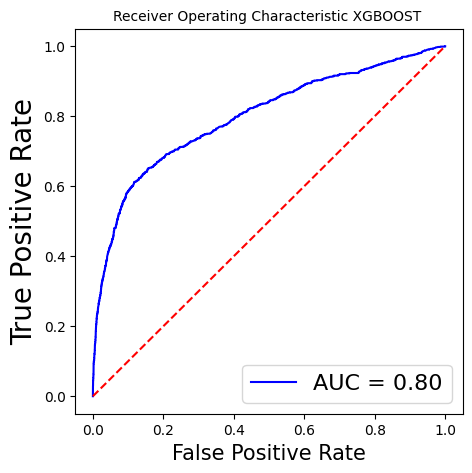

In [60]:
from sklearn import metrics
fig, ax = plt.subplots(figsize = (5,5))
#fig.set_size_inches(20, 8)
probs = xgb_model.predict_proba(X_test)
preds = probs[:,1]
fprxgb, tprxgb, thresholdxgb = metrics.roc_curve(y_test, preds)
roc_aucxgb = metrics.auc(fprxgb, tprxgb)

ax.plot(fprxgb, tprxgb, 'b', label = 'AUC = %0.2f' % roc_aucxgb)
ax.plot([0, 1], [0, 1],'r--')
ax.set_title('Receiver Operating Characteristic XGBOOST ',fontsize=10)
ax.set_ylabel('True Positive Rate',fontsize=20)
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.legend(loc = 'lower right', prop={'size': 16})

In [61]:
# get Top 10 important features
fi = xgb_model.steps[1][1].feature_importances_

In [62]:
fidf = pd.DataFrame(list(zip(all_features,fi)),
                   columns=['feature', 'importance'])
topfeature = fidf.sort_values('importance',ascending = False).head(10)

In [63]:
topfeature

,feature,importance
8,nr.employed,0.422566
61,poutcome__success,0.135216
4,emp.var.rate,0.070877
2,pdays,0.032537
6,cons.conf.idx,0.030985
52,month__oct,0.022441
50,month__may,0.018461
42,contact__cellular,0.016331
10,job__blue-collar,0.016292
59,poutcome__failure,0.013257


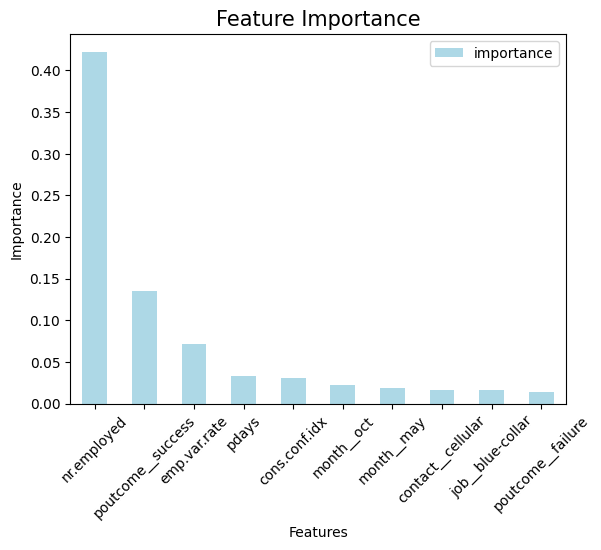

In [68]:

topfeature.plot.bar(x='feature',y='importance', color='lightblue')
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance',fontsize=15)
plt.show()

In [112]:
eli5.show_weights(xgb_model.named_steps['classifier'],feature_names=all_features)

Weight,Feature
0.4226,nr.employed
0.1352,poutcome__success
0.0709,emp.var.rate
0.0325,pdays
0.0310,cons.conf.idx
0.0224,month__oct
0.0185,month__may
0.0163,contact__cellular
0.0163,job__blue-collar
0.0133,poutcome__failure


### Kneighbors

In [123]:
kn_model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__numerical', 'preprocessor__categorical', 'preprocessor__numerical__copy', 'preprocessor__numerical__with_mean', 'preprocessor__numerical__with_std', 'preprocessor__categorical__categories', 'preprocessor__categorical__drop', 'preprocessor__categorical__dtype', 'preprocessor__categorical__handle_unknown', 'preprocessor__categorical__max_categories', 'preprocessor__categorical__min_frequency', 'preprocessor__categorical__sparse', 'preprocessor__categorical__sparse_output', 'classifier__algorithm', 'classifier__leaf_size', 'classifier__metric', 'classifier__metric_params', 'classifier__n_jobs', 'classifier__n_neighbors', 'classifier__p', 'classifier__weights'])

In [124]:
kn_gs = GridSearchCV(kn_model, {"classifier__n_neighbors": [3,5]},
                  n_jobs=1, cv=k_fold, scoring="accuracy")
kn_gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=3, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                                                          'emp.var.rate',
                                                                          'cons.price.idx',
                                                                          'cons.conf.idx',
                                                                          'euribor3m',
                                                                          'nr.employed']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week',
                                                                          'poutcome'])])),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=1, param_grid={'classifier__n_neighbors': [3, 5]},
             scoring='accuracy')

In [125]:
print(kn_gs.best_params_)
print(kn_gs.best_score_)
kn_model.set_params(**kn_gs.best_params_)
kn_model.fit(X_train,y_train)
y_pred_kn = kn_model.predict(X_test)
print('accuracy score: ', accuracy_score(y_test, y_pred_kn))
print('report: ', classification_report(y_test, y_pred_kn))
ac_score['kn']= accuracy_score(y_test,y_pred_kn )

{'classifier__n_neighbors': 5}
0.8897996357012751
accuracy score:  0.8920592520641087
report:                precision    recall  f1-score   support

           0       0.92      0.97      0.94      7308
           1       0.54      0.30      0.39       928

    accuracy                           0.89      8236
   macro avg       0.73      0.63      0.66      8236
weighted avg       0.87      0.89      0.88      8236



In [127]:
print(ac_score)

{'lr': 0.825643516270034, 'dt': 0.8453132588635259, 'rf': 0.8842884895580378, 'xgb': 0.9027440505099563, 'kn': 0.8920592520641087}
